In [1]:
import scipy.io
import numpy as np
import pylab as pl
from src.read_data import lire_alpha_digits
from src.principal_DBN_alpha import DbnModel

In [2]:
mat = scipy.io.loadmat('data/binaryalphadigs.mat')
data_digits = mat['dat'][:10,]
data_alpha = mat['dat'][10:,]
print("data_digits shape = {}".format(data_digits.shape))
print("data_alpha shape = {}".format(data_alpha.shape))

data_digits shape = (10, 39)
data_alpha shape = (26, 39)


In [3]:
data_alpha_reshaped = lire_alpha_digits(data_alpha, [0])
data_digits_reshaped = lire_alpha_digits(data_digits, [0])

Training Layer 1/2 ...
Training Layer 2/2 ...


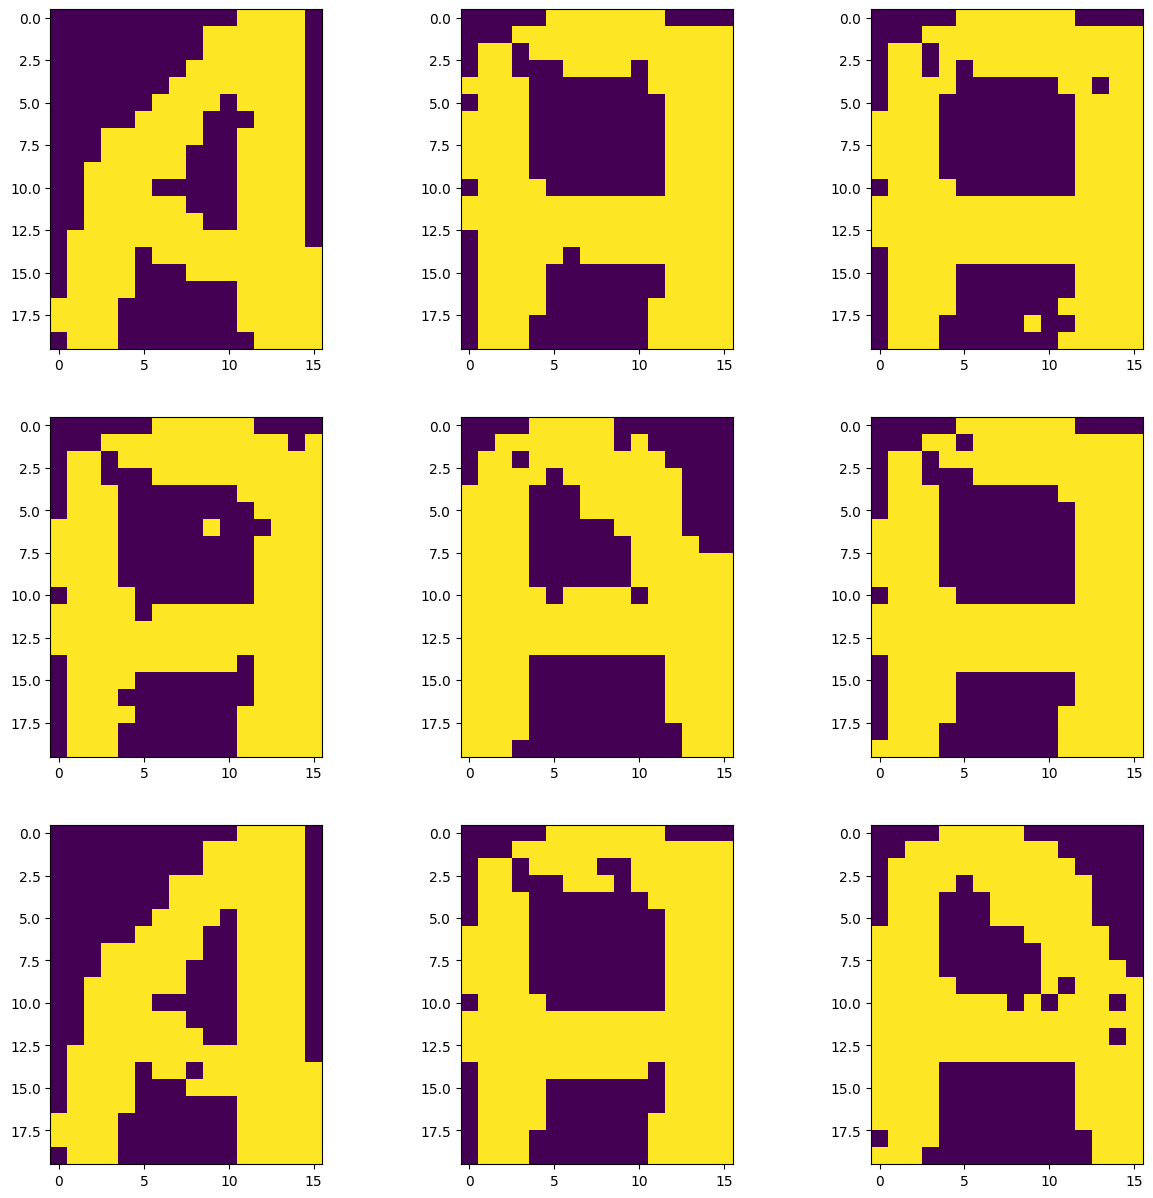

In [4]:
dbn = DbnModel(d=2, p=320, q=150)
dbn.train_DBN(data_alpha_reshaped, 400, 0.01, 10)
gen = dbn.generer_image_DBN(9, 300)

fig, ax = pl.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    for j in range(3):
        ax[i, j].imshow(gen[3*i + j,:].reshape(20,16))